In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import pickle as pk
from sklearn import linear_model
import time
from skl_groups.features import Features
from skl_groups.summaries import BagOfWords
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from mpl_toolkits.axes_grid1 import *
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
import scipy
from skl_groups.kernels import PairwisePicker, Symmetrize, RBFize, ProjectPSD

%matplotlib inline

In [2]:
# load kernel file
def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print "Similarities loaded!"
    return loader['similarities']

kernelFN = "./simulatedData/kernel-2000-sym-v2"
kl_sym = loadSimilarities(kernelFN)
# Note: loaded kernel is the result of
# - building the KNN graph using KL divergence
# - symmeterizing the graph: KL is not a distance and is not symmetric, we need distance-symmetry behavior because next step is...
# - passing the symmeterized graph through a radial basis function (RBF): Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure
# - projecting the output of the RBF to a positive semi-definite space: 

Similarities loaded!


0.0 0.335837 11.1674


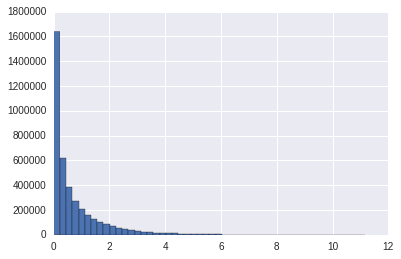

In [3]:
print kl_sym.min(), np.median(kl_sym.flatten()), kl_sym.max()
_ = plt.hist(kl_sym.flatten(),50)

7.5596e-07 0.987333 1.0


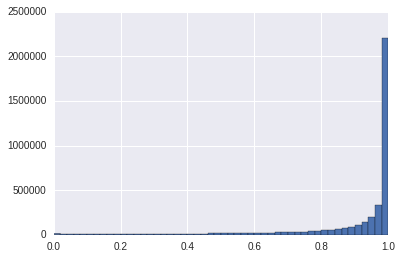

In [4]:
assert (kl_sym == kl_sym.T).all()
rbf = RBFize(gamma=1, scale_by_median=True)
kl_rbf = rbf.fit_transform(kl_sym)
print kl_rbf.min(),np.median(kl_rbf) ,kl_rbf.max()
_ = plt.hist(kl_rbf.flatten(),50)

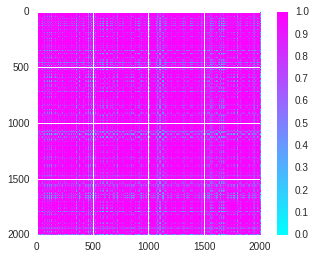

In [5]:
plt.imshow(kl_rbf, vmin=0.0, vmax=1.0, cmap='cool')
plt.colorbar()

1.22238e-38 0.924086 1.0


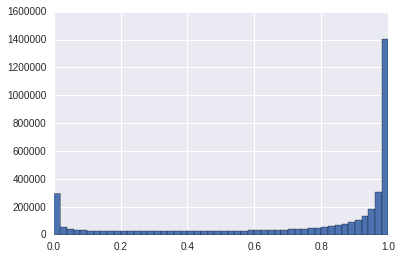

In [6]:
assert (kl_sym == kl_sym.T).all()
rbf = RBFize(gamma=0.7, scale_by_median=False)
kl_rbf = rbf.fit_transform(kl_sym)
print kl_rbf.min(),np.median(kl_rbf) ,kl_rbf.max()
_ = plt.hist(kl_rbf.flatten(),50)

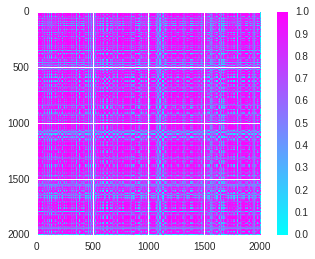

In [7]:
plt.imshow(kl_rbf, vmin=0.0, vmax=1.0, cmap='cool')
plt.colorbar()

In [8]:
psd = ProjectPSD()
kernel = psd.fit_transform(kl_rbf)

This is some information the projected kernel :
min, median, max value of the kernel: -0.189586 0.849475 1.68562
less than 0.3 :0.157526
less than 0.5 :0.2419485
less than 1.0 :0.7336405
-----------
number of subject with at least one entry higher than 1: 2000
These are diagonal elements: [ 1.34703076  1.42615283  1.34304988 ...,  1.36714137  1.38754511
  1.37470627]


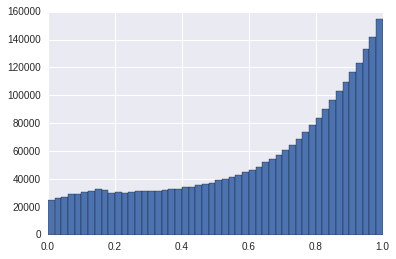

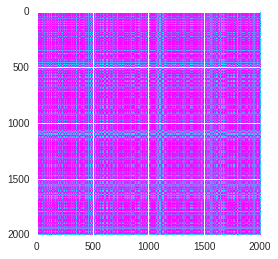

In [9]:
# Numerical checking
print "This is some information the projected kernel :"
print "min, median, max value of the kernel: " + str(np.min(kernel)) + " " + str(np.median(kernel)) +" "+ str(np.max(kernel))
print "less than 0.3 :" + str(np.sum(kernel.flatten() < 0.3)/np.float(np.prod(kernel.shape)))
print "less than 0.5 :" + str(np.sum(kernel.flatten() < 0.5)/np.float(np.prod(kernel.shape)))
print "less than 1.0 :" + str(np.sum(kernel.flatten() < 1)/np.float(np.prod(kernel.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernel > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernel))

plt.figure()
# _ = plt.hist(kernel.flatten()[:],50)
_ = plt.hist(kernel.flatten()[np.logical_and(kernel.flatten() < 1 , kernel.flatten() > 0) ],50)


plt.figure()
# plt.imshow(kernel, cmap='cool')
plt.imshow(kernel, vmin=0, vmax=1.0, cmap='cool')

In [10]:
# idx = np.where(kernel < 0.0)
# plt.imshow(kernel[idx[0]][idx[1]], cmap='cool')

In [11]:
# cholesky factorization

# ============== cholesky
# K_PSD is the result of projection -> loaded kernel data
regParam =  1e-3
# perform the cholesky factorization
hidim = np.linalg.cholesky(kernel+(regParam*np.eye(kernel.shape[0])))

In [12]:
# =================== embedding for patient
# transform the cholesky factorization into a set of 2D features to use in the visualization
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # 
tSNE = tsne.fit_transform(hidim)   # hidim is the cholesky factorization

#clf = LocallyLinearEmbedding(n_c omponents=d)
#tSNE = clf.fit_transform(hidim)    

# plot 2d embedding

In [13]:
def loadSimSubjects(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - features: single patient's features/nodes
    - ids: subject ids
    - y: the label (number of abnormal nodes)
    """
    with open(fn+"-feats.data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print "Simluated patient features and metadata loaded!"
    return loader['ids'], np.asarray(loader['y']), loader['features']

# load the list of the number of abnormal nodes for each subject
patientsFN = "./simulatedData/simulatedSubjects"
ids, subjClasses, subjFeatures = loadSimSubjects(patientsFN)
# get a list of permuted indices to use - not necessary?
permIdx = np.random.permutation(range(len(ids)))
subjClasses_subset = np.array(subjClasses)[permIdx[:3000]]    
tSNE_subset = tSNE[permIdx[:3000]]


Simluated patient features and metadata loaded!


In [14]:
def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

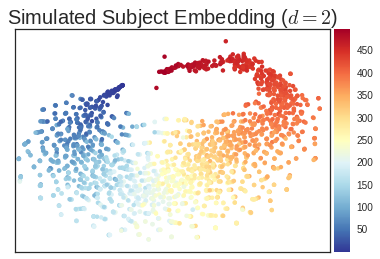

In [39]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNE_subset, subjClasses_subset, 
                    ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-18,15])
ax1.set_ylim([-18,20])
ax1.set_title('Simulated Subject Embedding ($d=2$)',fontsize=20)

In [25]:
# ========== extracting higher dim features per subject
clf = LocallyLinearEmbedding(n_components=100)
LLE_modified = clf.fit_transform(hidim)   # this is your X, ie your feature per subject

print LLE_modified.shape

(2000, 100)


In [35]:
# ======== Regression
numPCA_comp = 100
colNameList = []
for numDim in range(2,numPCA_comp,10):
    colNameList.append(['LLE_modified_f%d'%i for i in range(numDim)])

score_r2DictList = {}
p_r2DictList = {}
accScoreDictList = {}
p_accDictList = {}    
    
featureName = 'histFHOG_largeRange_setting1'
score_r2DictList[featureName] = []
p_r2DictList[featureName] = []
accScoreDictList[featureName] = []
p_accDictList[featureName] = []

In [36]:
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s

In [40]:
for colName in colNameList:
    #---------------------  Compute BOW
    t0 = time.clock()
    print "computing bag of words ......"
    feats = Features(subjFeatures)      # here the data is your patient patch data - list of patch features
    bow = BagOfWords(KMeans(n_clusters=len(colName), max_iter=100, n_init=2))
    bowized = bow.fit_transform(feats)
    print "Bag of words computed!"
    print time.time() - t0
    
    X = LLE_modified[:,:len(colName)]
    
    print "Shape of bow: " + str(bowized.shape)
    print "Column name: " + str(colName)
    print "Len(colName): " + str(len(colName))
    print "X.shape: " + str(X.shape)

    # make a cross-validation object
    cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)

    ### regression
    allXy = {}    
    yName = 'FEV1pp_utah'    

    
#     allXy['SimulatedNNFeats'] = (X,y)
#     allXy['BOW'] = (bowized,y)
    y = np.asarray(subjClasses)  # loaded earlier as the number of abnormal nodes in the subject
    allXy['SimulatedNNFeats'] = (X, y)   # is X supposed to be the patch features?
    allXy['BOW'] = (bowized, y)    # replaced y with subjList


    score_r2Dict = {}
    p_r2Dict = {}
    for k in allXy.keys():         
        #clf = linear_model.Ridge(alpha=1)
        score_r2Dict[k] = [] 
        #score_r2Dict[k] = cross_val_score(clf, allXy[k][0], allXy[k][1], cv=50, scoring='r2_score')
        print "working on ",k, "...."
        for i, (train, test) in enumerate(cv):
            clf = linear_model.Ridge(alpha=1)
            r2,s = evalFeatures_Regression(allXy[k][0][train],    # your X (LLE_modified)
                                           allXy[k][1][train],    # your y 
                                           allXy[k][0][test],     # your X
                                           allXy[k][1][test],clf) # your y
            score_r2Dict[k].append(r2)

    # add the results to a list
    score_r2DictList[featureName].append(score_r2Dict)
    p_r2DictList[featureName].append(p_r2Dict)
#     accScoreDictList[featureName].append(accScoreDict)
#     p_accDictList[featureName].append(p_accDict)
    

resultsRoot = './simulatedData/evaluation'
pk.dump( score_r2DictList, open(resultsRoot + "/linReg_score_r2DictList.p",'wb') )
pk.dump( p_r2DictList, open(resultsRoot + "/linReg_p_r2DictList.p",'wb') )
# pk.dump( accScoreDictList, open(hellingerRoot + "/linReg_accScoreDictList.p",'wb') )
# pk.dump( p_accDictList, open(hellingerRoot + "/linReg_p_accDictList.p",'wb') )

computing bag of words ......
Bag of words computed!
1480894818.17
Shape of bow: (2000, 2)
Column name: ['LLE_modified_f0', 'LLE_modified_f1']
Len(colName): 2
X.shape: (2000, 2)
working on  SimulatedNNFeats ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894827.22
Shape of bow: (2000, 12)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11']
Len(colName): 12
X.shape: (2000, 12)
working on  SimulatedNNFeats ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894850.17
Shape of bow: (2000, 22)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21']
Len(colName): 22
X.shape: (2000, 22)
working on  SimulatedNNFeats ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894900.36
Shape of bow: (2000, 32)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31']
Len(colName): 32
X.shape: (2000, 32)
working on  SimulatedNNFeats ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894935.83
Shape of bow: (2000, 42)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41']
Len(colName): 42
X.shape: (2000, 42)
working on  SimulatedNNFeats ....
working on  BOW ....
co

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894957.59
Shape of bow: (2000, 52)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE_modified_f45', 'LLE_modified_

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1480894958.06
Shape of bow: (2000, 62)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE_modified_f45', 'LLE_modified_

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1480894999.98
Shape of bow: (2000, 72)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1480895012.63
Shape of bow: (2000, 82)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1480895015.46
Shape of bow: (2000, 92)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

In [ ]:
# plot 
# compute average of the 50 folds for all 

In [9]:
# Figures for Vanathi
# histogram of how many abnormal nodes are present in each subject
plt.figure()
plt.hist(subjList)

# allXy = {}    
# yName = 'FEV1pp_utah'

# allXy['SimulatedNNFeats'] = (LLE_modified,subjList)   # is X supposed to be the patch features?
# allXy['BOW'] = (bowized,subjList)    # replaced y with subjList
# print type(allXy['SimulatedNNFeats'][1])

NameError: name 'subjList' is not defined